# Clustering birdsong

In [1]:
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as transforms
from torchvision.transforms import Compose
from tqdm.notebook import tqdm

### Define paths

In [2]:
dataset_path = Path.cwd() / "3_5_data" / "wavfiles"
file_list = list(dataset_path.glob("*.wav"))

### Select device (CPU or GPU)

Neural networks can be trained on a CPU or a GPU. The latter is much faster, but requires a compatible GPU.
If you have a GPU, you can enable it by setting `device` to `'cuda'`. Otherwise, set it to `'cpu'`.
Apple computers do not support CUDA, but PyTorch now ships with the Metal Performance Shaders (MPS) backend for accelerated training on macOS.
To enable it, set `device` to `'metal'`.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: mps


### Define a custom Dataset class for loading birdsong data

To simplify the process of loading the birdsong data, we define a custom Dataset class that inherits from PyTorch's Dataset class.
This class will load the audio files and their corresponding labels.
Under the hood, the dataclass module is rather efficient in terms of memory usage and speed.

Data in the birdsong dataset are already normalized between $[-1, 1]$. However, if further transformations are needed, they can be supplied to the `__init__` method with the `transform` argument. For example, one could supply a callable that transforms the time series to a spectrogram.

In [4]:
class AudioDataset(Dataset):
    def __init__(
        self, file_list: list[Path], transform: Any | None = None, device: str = "cpu"
    ) -> None:
        self.file_list = file_list
        self.transform = transform
        self.device = device

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        audio_file = self.file_list[idx]
        audio_data, sample_rate = torchaudio.load(audio_file)

        if self.transform:
            audio_data = self.transform(audio_data)

        return audio_data.to(self.device), sample_rate

### Load some data and visualize it

Data shape: torch.Size([256, 1, 66150])
Sample rate: 22050 Hz


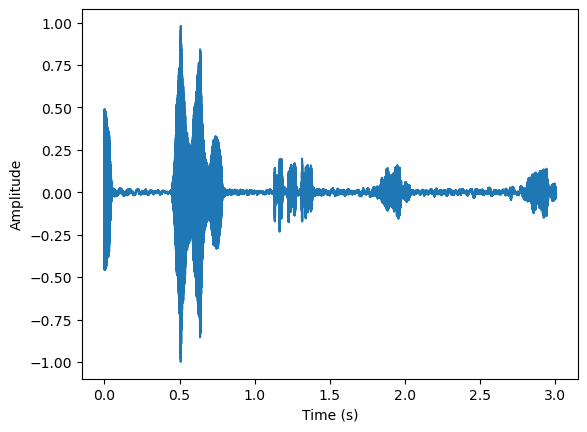

In [5]:
ts_dataset = AudioDataset(file_list, device=device)
ts_dataloader = DataLoader(ts_dataset, batch_size=256, shuffle=True)

data, sampling_rates = next(iter(ts_dataloader))
print(f"Data shape: {data.shape}")
print(f"Sample rate: {sampling_rates[0]} Hz")

num_samples = data.shape[-1]
times = np.linspace(0, num_samples / sampling_rates[0], num_samples)

plt.figure()
plt.plot(times, data[0].cpu().numpy().squeeze())
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Transform data using a spectrogram

In [6]:
def normalize_to_zero_one(spectrogram):
    return (spectrogram - spectrogram.min()) / (
        spectrogram.max() - spectrogram.min() + 1e-10
    )


transform = Compose(
    [
        transforms.Spectrogram(n_fft=1024, hop_length=512, power=1),
        normalize_to_zero_one,
    ]
)
dataset = AudioDataset(file_list, transform=transform, device=device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
# data, _ = next(iter(dataloader))
# print(f"Spectrogram shape: {data.shape}")
# print(data[0].min(), data[0].max())

# plt.figure()
# plt.imshow(data[0].cpu().numpy().squeeze(), aspect="auto", origin="lower")
# plt.colorbar()
# plt.title("Spectrogram")
# plt.xlabel("Time (frames)")
# plt.ylabel("Mel Frequency (bins)")
# plt.show()

## Dimensionality Reduction using an autoencoder

### Define the autoencoder architecture

The autoencoder is a neural network that learns to compress the input data into a lower-dimensional representation and then reconstruct it back to the original input.
The implementation of the network here is symmetrical, but this is not a requirement.

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=10):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder - 4 convolutional layers with ReLU activations
        self.encoder = nn.Sequential(
            # Layer 1: [batch, in_channels, H, W] -> [batch, 32, H/2, W/2]
            nn.Conv2d(in_channels, 32, kernel_size=5, stride=3, padding=1),
            nn.ReLU(True),
            
            # Layer 2: [batch, 32, H/2, W/2] -> [batch, 64, H/4, W/4]
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            
            # Layer 3: [batch, 64, H/4, W/4] -> [batch, 128, H/8, W/8]
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            
            # Layer 4: [batch, 128, H/8, W/8] -> [batch, 256, H/16, W/16]
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
        )
        
        # Decoder - 4 transposed convolutional layers with ReLU activations
        self.decoder = nn.Sequential(
            # Layer 1: [batch, 256, H/16, W/16] -> [batch, 128, H/8, W/8]
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            # Layer 2: [batch, 128, H/8, W/8] -> [batch, 64, H/4, W/4]
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            # Layer 3: [batch, 64, H/4, W/4] -> [batch, 32, H/2, W/2]
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            # Layer 4: [batch, 32, H/2, W/2] -> [batch, in_channels, H, W]
            nn.ConvTranspose2d(32, in_channels, kernel_size=5, stride=3, padding=1, output_padding=1),
            # No activation on final layer for flexibility
            # nn.Sigmoid()  # Uncomment if output should be between 0 and 1
        )
        
        self.latent_dim = latent_dim
        self.fc_encoder = None
        self.fc_decoder = None
        self.initialized = False
        
        # Store dimensions for proper reshaping
        self.feature_size = 256
        self.height_factor = 16  # Input height will be divided by this
        self.width_factor = 16   # Input width will be divided by this
        
        # Apply Xavier uniform initialization to all existing layers
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Apply Xavier uniform initialization to Conv2d, ConvTranspose2d, and Linear layers
        """
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Save original input dimensions
        original_shape = x.shape
        
        # Get the device of the input tensor
        device = x.device
        
        # Pass through encoder
        encoded = self.encoder(x)
        
        # Get current dimensions
        batch_size = encoded.size(0)
        feature_size = encoded.size(1)
        height = encoded.size(2)
        width = encoded.size(3)
        flat_size = feature_size * height * width
        
        # Initialize FC layers if not done already (only once)
        if not self.initialized:
            self.fc_encoder = nn.Linear(flat_size, self.latent_dim).to(device)
            self.fc_decoder = nn.Linear(self.latent_dim, flat_size).to(device)
            
            # Apply Xavier initialization
            nn.init.xavier_uniform_(self.fc_encoder.weight)
            nn.init.zeros_(self.fc_encoder.bias)
            nn.init.xavier_uniform_(self.fc_decoder.weight)
            nn.init.zeros_(self.fc_decoder.bias)
            
            # Store dimensions for future forward passes
            self.feature_size = feature_size
            self.encoder_height = height
            self.encoder_width = width
            
            self.initialized = True
        
        # Flatten the feature maps
        flattened = encoded.view(batch_size, -1)
        
        # Project to latent space
        z = self.fc_encoder(flattened)
        
        # Project back to feature map dimensions
        decoded_flat = self.fc_decoder(z)
        
        # Reshape to encoder output dimensions
        decoded_conv = decoded_flat.view(batch_size, self.feature_size, self.encoder_height, self.encoder_width)
        
        # Pass through decoder
        output = self.decoder(decoded_conv)
        
        # Ensure output dimensions match input dimensions
        if output.shape != original_shape:
            output = nn.functional.interpolate(output, size=(original_shape[2], original_shape[3]), mode='bilinear', align_corners=False)
        
        return output, z  # Return both the reconstructed image and the latent representation

### Initialize the autoencoder

In this step, we instantiate the autoencoder model and initialize its weights.
We also define the loss function (mean squared error, MSE) and the optimizer (AdamW).

In [8]:
autoencoder = ConvAutoencoder(in_channels=1, latent_dim=12)
print(autoencoder)
trainable_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

criterion = nn.MSELoss()
optimizer = optim.AdamW(autoencoder.parameters(), lr=0.00001)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), output_padding=(1, 1))
 

### Train the autoencoder

The autoencoder is trained by training the network on mini-batches of data.
The training loop consists of the following steps:
1. Forward pass: The input data is passed through the autoencoder to obtain the output.
2. Compute the loss: The MSE loss is computed between the output and the input.
3. Backward pass: The gradients of the loss with respect to the weights are computed.
4. Update the weights: The optimizer updates the weights of the network using the gradients.
5. Repeat steps 1-4 for a set number of *epochs*.

The best model corresponds to the one with the lowest loss and is saved for future use.

In [ ]:
autoencoder = autoencoder.to(device)
criterion = criterion.to(device)
num_epochs = 50

best_loss = torch.inf
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    for x, _ in pbar:
        x_r, z = autoencoder(x)
        loss = criterion(x_r, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"MSE": loss.item()})

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(autoencoder.state_dict(), dataset_path.parent / "best_model.pth")

Epoch 1:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/72 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Retrieve best autoencoder model

With training complete, we can now load the best model and use it to encode the data.
The model is placed in `eval` mode for inference (i.e., only the forward pass is performed).

In [ ]:
autoencoder.load_state_dict(torch.load(dataset_path.parent / "best_model.pth"))
autoencoder.eval()

### Perform inference on the data

The autoencoder is used to encode the data into a lower-dimensional representation.
Here we use the `dataloader` to iterate through the mini-batches of data and encode them using the autoencoder.

### Visualize the original data and reconstructed data

In [ ]:
with torch.no_grad():
    x, _ = next(iter(dataloader))
    x_r, z = autoencoder(x)

fig, axs = plt.subplots(ncols=3, figsize=(12, 6), gridspec_kw={"width_ratios": [1, 0.1, 1]})
ax = axs[0]
ax.imshow(x[0].cpu().numpy().squeeze(), aspect="auto", origin="lower", cmap="plasma")
ax.set_xlabel("Time bins")
ax.set_ylabel("Frequency bins")
ax.set_title("Original Spectrogram")

ax = axs[1]
ax.imshow(z[0].cpu().numpy()[..., np.newaxis], aspect="auto", origin="lower")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title("Latent Embeddings")

ax = axs[2]
ax.imshow(x_r[0].cpu().numpy().squeeze(), aspect="auto", origin="lower", cmap="plasma")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlabel("Time bins")
ax.set_ylabel("Frequency bins")
ax.set_title("Reconstructed Spectrogram")
plt.tight_layout()
plt.show()